In [1]:
#import findspark
#findspark.init()
import pyspark

import pandas as pd
import os
import matplotlib.pyplot as plt
#import seaborn as sns
%matplotlib inline
from pyspark.sql import SparkSession

In [2]:
spark= SparkSession.builder.appName("TPCH Data Z=0.5").getOrCreate()
#spark = SparkSession.builder.master("spark://sp-manager:7077").appName("Practice1").getOrCreate()

23/04/05 15:49:16 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


In [3]:
spark

In [4]:
def load_table(filename):
    tpch_df = spark.read.format('csv') \
    .option('header', 'false') \
    .option('delimiter', '|') \
    .load(filename, inferSchema='true')    
    return tpch_df

def getFieldList(tablename):
    dss_ddl_file = tpch_home + "/dss.ddl"
    table=tablename
    with open(dss_ddl_file, 'r') as file:
        data = file.read()
    str_pos= data.index(table)
    end_pos= data.index(";",str_pos)
    data=data[str_pos+len(table)+3: end_pos]    
    data =[i.strip()for i in data.split("\n")]
    fields=[]
    for line in data:
        fields.append(line.split()[0])
    return fields   

In [5]:
#tpch_home = "/usr/share/ApacheSpark/data/tpch/TPC-H-V3.0.1/dbgen"
tpch_home = "/usr/share/ApacheSpark/data/tpch/TPC-H-Skew"

z_val=[0,0.7,1,2]
z_folder= ["z_default", "z_0_7", "z_1", "z_2"]
tpch_df=[]

for i,z in enumerate(z_val):
    z_path=z_folder[i]
    path= tpch_home + "/"+ z_path
    print(path)
    tablename= "lineitem.tbl";
    filename= path + "/"+tablename
    tpch_df.append(load_table(filename))

/usr/share/ApacheSpark/data/tpch/TPC-H-Skew/z_default


/usr/share/ApacheSpark/data/tpch/TPC-H-Skew/z_0_7


/usr/share/ApacheSpark/data/tpch/TPC-H-Skew/z_1
/usr/share/ApacheSpark/data/tpch/TPC-H-Skew/z_2


In [6]:
tpch_df1=[]
for i,z in enumerate(z_val):
    print(f"Total Rows in {tablename} (z={z}):", tpch_df[i].count())
    tpch_df[i].printSchema()
    tblname="lineitem_tbl"+z_folder[i]
    tpch_df[i].createOrReplaceTempView(tblname)
    tpch_df1.append(spark.sql("select _c4,_c5,_c6, _c10, _c11, _c12 from "+tblname))

Total Rows in lineitem.tbl (z=0): 600000
root
 |-- _c0: integer (nullable = true)
 |-- _c1: integer (nullable = true)
 |-- _c2: integer (nullable = true)
 |-- _c3: integer (nullable = true)
 |-- _c4: integer (nullable = true)
 |-- _c5: double (nullable = true)
 |-- _c6: double (nullable = true)
 |-- _c7: double (nullable = true)
 |-- _c8: string (nullable = true)
 |-- _c9: string (nullable = true)
 |-- _c10: timestamp (nullable = true)
 |-- _c11: timestamp (nullable = true)
 |-- _c12: timestamp (nullable = true)
 |-- _c13: string (nullable = true)
 |-- _c14: string (nullable = true)
 |-- _c15: string (nullable = true)
 |-- _c16: string (nullable = true)

Total Rows in lineitem.tbl (z=0.7): 600000
root
 |-- _c0: integer (nullable = true)
 |-- _c1: integer (nullable = true)
 |-- _c2: integer (nullable = true)
 |-- _c3: integer (nullable = true)
 |-- _c4: integer (nullable = true)
 |-- _c5: double (nullable = true)
 |-- _c6: double (nullable = true)
 |-- _c7: double (nullable = true)
 |--

In [7]:
all_col_list=tpch_df[0].columns
field_List= getFieldList(tablename="LINEITEM")
for i,label in enumerate(field_List):
    print(i,label)

0 L_ORDERKEY
1 L_PARTKEY
2 L_SUPPKEY
3 L_LINENUMBER
4 L_QUANTITY
5 L_EXTENDEDPRICE
6 L_DISCOUNT
7 L_TAX
8 L_RETURNFLAG
9 L_LINESTATUS
10 L_SHIPDATE
11 L_COMMITDATE
12 L_RECEIPTDATE
13 L_SHIPINSTRUCT
14 L_SHIPMODE
15 L_COMMENT


In [8]:
for i in range(len(z_val)):
    tpch_df1[i].show(2)

+---+--------+----+-------------------+-------------------+-------------------+
|_c4|     _c5| _c6|               _c10|               _c11|               _c12|
+---+--------+----+-------------------+-------------------+-------------------+
| 17|24386.67|0.04|1996-03-13 00:00:00|1996-02-12 00:00:00|1996-03-22 00:00:00|
| 36|58958.28|0.09|1996-04-12 00:00:00|1996-02-28 00:00:00|1996-04-20 00:00:00|
+---+--------+----+-------------------+-------------------+-------------------+
only showing top 2 rows

+---+--------+----+-------------------+-------------------+-------------------+
|_c4|     _c5| _c6|               _c10|               _c11|               _c12|
+---+--------+----+-------------------+-------------------+-------------------+
| 17|24386.67|0.04|1996-03-13 00:00:00|1996-02-12 00:00:00|1996-03-22 00:00:00|
| 17|24386.67|0.04|1996-03-13 00:00:00|1996-02-12 00:00:00|1996-03-22 00:00:00|
+---+--------+----+-------------------+-------------------+-------------------+
only showing to

How to get data from spark dataframe to python

In [9]:
from matplotlib import colors
from matplotlib.ticker import PercentFormatter
import warnings
warnings.filterwarnings("ignore")  # Ignore warnings coming from Arrow optimizations.

# Create a random number generator with a fixed seed for reproducibility
n_bins = 20

def plot_hist(col):
    field_label = field_List[all_col_list.index(col)]
    print(field_label)
    for i in range(len(z_val)):
        psdf = tpch_df1[i].select(col).pandas_api()
        dist1= psdf
        fig, axs = plt.subplots(1, 1)
        axs.hist(dist1, bins=n_bins)
        z=z_val[i]
        axs.set_title(f"z={z}")


def plot_hist1(col):
    field_label = field_List[all_col_list.index(col)]
    fig, axs = plt.subplots(1, 3, sharey=False, tight_layout=False)
    print(field_label)
    for i in range(len(z_val)):
        psdf = tpch_df1[i].select(col).pandas_api()
        dist1= psdf        
        axs[i].hist(dist1, bins=n_bins)
        z=z_val[i]
        axs[i].set_title(f"z={z}")        

L_EXTENDEDPRICE


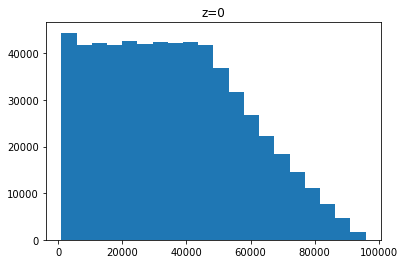

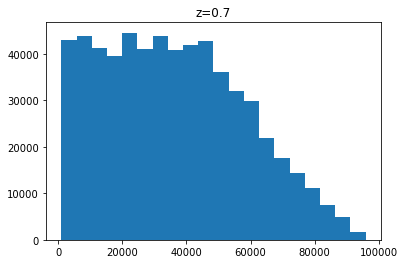

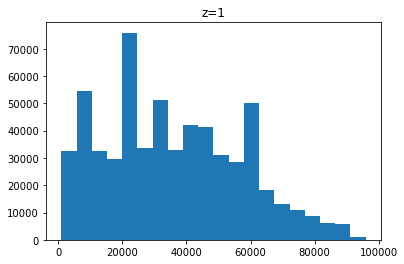

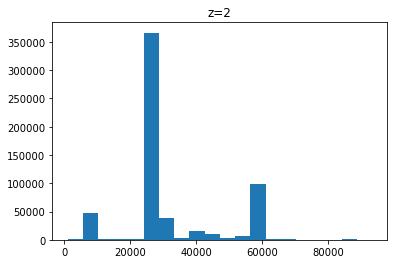

In [10]:
col="_c5"
plot_hist(col)

L_QUANTITY


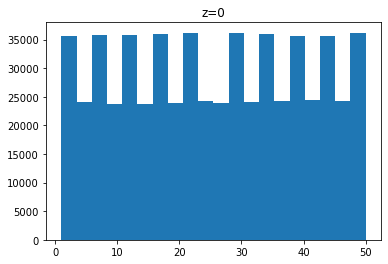

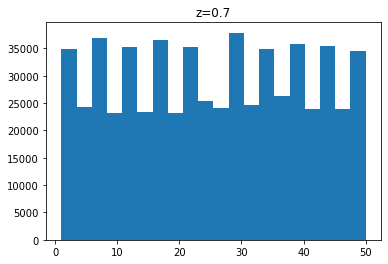

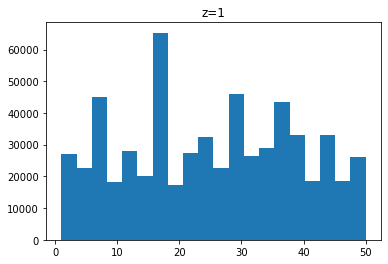

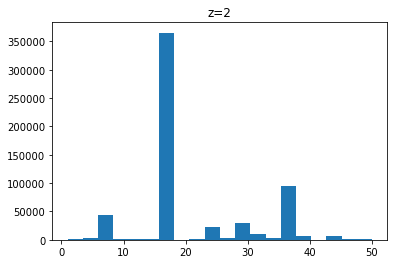

In [11]:
col="_c4"
plot_hist(col)

L_COMMITDATE


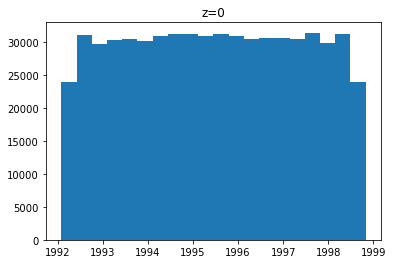

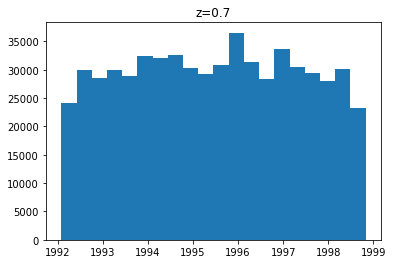

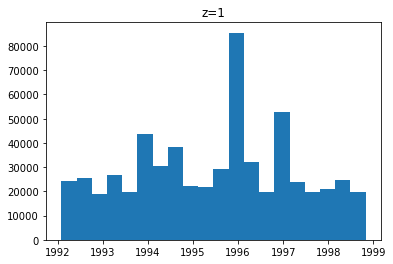

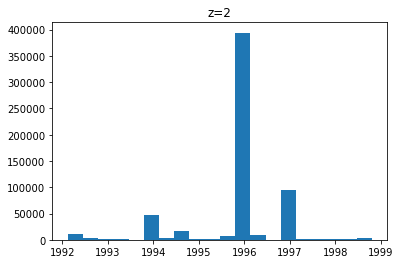

In [12]:
col="_c11"
plot_hist(col)

In [ ]:
spark.stop()